## Customer Segmentation by RFM (Recency, Frequency, Monetary)

In [64]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

from datetime import datetime
from sklearn.cluster import KMeans
from functools import wraps

sns.set_context('talk')
sns.set_style('whitegrid')
sns.set_palette('husl')

In [2]:
# Read excel file to dataframe
df = pd.read_excel('OnlineRetail.xlsx')
# Turn letter to lower case for easy coding
df.columns = df.columns.str.lower()

In [3]:
#Subset United Kingdom only 
df = df[df.country == 'United Kingdom']

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 495478 entries, 0 to 541893
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   invoiceno    495478 non-null  object        
 1   stockcode    495478 non-null  object        
 2   description  494024 non-null  object        
 3   quantity     495478 non-null  int64         
 4   invoicedate  495478 non-null  datetime64[ns]
 5   unitprice    495478 non-null  float64       
 6   customerid   361878 non-null  float64       
 7   country      495478 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 34.0+ MB


In [5]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
quantity,495478.0,8.605486,227.588756,-80995.00,1.00,3.0,10.00,80995.0
unitprice,495478.0,4.532422,99.315438,-11062.06,1.25,2.1,4.13,38970.0
customerid,361878.0,15547.871368,1594.402590,12346.00,14194.00,15514.0,16931.00,18287.0


In [3]:
df.head()

,invoiceno,stockcode,description,quantity,invoicedate,unitprice,customerid,country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


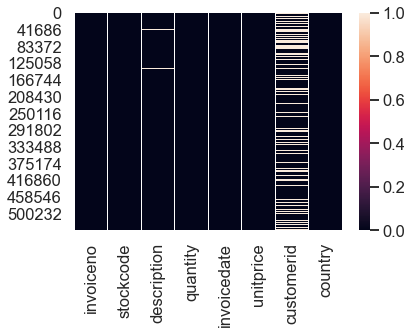

In [4]:
sns.heatmap(df.isnull())

In [5]:
df.loc[df.description.isnull(), 'description'] = 'N/A'

In [6]:
# drop customerid's null values since we are trying to cluster customer, and without customer id
# we won't be able to know who is the customer. We can't impute missing values because this is a
#primary key. 
df.dropna(axis=0, inplace=True)

In [7]:
df.isnull().sum()

invoiceno      0
stockcode      0
description    0
quantity       0
invoicedate    0
unitprice      0
customerid     0
country        0
dtype: int64

### Define Decorator & Class

In [8]:
# Define decorator timer
def timer(func):
    """A decorator that prints how long a function took to run"""
    
    @wraps(func)
    def wrapper(*args, **kwargs):
        start = time.time()
        result = func(*args, **kwargs)
        total = time.time() - start
        print(f'{total:.2f}s runtime on {func.__name__} function')
        return result
    return wrapper

In [9]:
# Define ClusterK class
class Cluster:
    def __init__(self):
        pass
    
    @timer
    def predict(self, n_clusters, data):
        """Use Kmeans to predict cluster for input data"""
        
        kmean = KMeans(n_clusters=n_clusters, max_iter=1000)
        kmean.fit(data)
        predictions = kmean.predict(data)
        return predictions
    
    @timer   
    def elbow(self, data):
        """Elbow method compute number of clusters and distance
            Return:
            INT(number of cluster)
            INT(distance)       
        """
        distance = []
        k_range = range(1,10)
        for k in k_range:
            km = KMeans(n_clusters=k, max_iter=1000).fit(data)           
            distance.append(km.inertia_)
        return k_range, distance
    
    def plot_elbow(self, k_range, distance):
        """Plot elbow on lineplot"""
        
        sns.lineplot(k_range, distance, marker='o')
        plt.xlabel('Number of Cluster'); plt.ylabel('Distance')
        plt.title('Elbow Method for Optimal K')
        plt.show()
        
    @timer   
    def cluster_order(self, cluster_name, target_name, df, ascending):
        """ Re-order cluster labels so labels looks neat and easy to understand.
        Cluster 0 would be most favourable
        """
        
        df_new = df.groupby(cluster_name)[target_name].mean().reset_index()
        df_new = df_new.sort_values(target_name, ascending=ascending).reset_index(drop=True)
        df_new['index'] = df_new.index
        df_final = pd.merge(df, df_new[[cluster_name, 'index']], on=cluster_name)
        df_final.drop(cluster_name, axis=1, inplace=True)
        df_final.rename(columns={'index': cluster_name}, inplace=True)
        return df_final

## 1. Recency

In [10]:
# Create new dataframe by unique customer id
user = pd.DataFrame(df['customerid'].unique(), columns=['customer_id'])

# Subset recent invoice date by customer id as their purchase history
purchase_history = df.groupby('customerid').invoicedate.max().reset_index()
purchase_history.columns = ['customer_id', 'recent_purchase_date']

# Compute number of days since their last purchase from recent date
purchase_history['recency'] = (purchase_history['recent_purchase_date'].max() - purchase_history['recent_purchase_date']).dt.days

# Merge user & purchase_history
user = user.merge(purchase_history[['customer_id', 'recency']], on='customer_id')

In [11]:
# customer #17850 last purchase was 301 days from the most recent invoice date
# Likewise, customer #12583 purchased a product 2 days ago from the most recent invoice date
user.head()

,customer_id,recency
0,17850.0,301
1,13047.0,31
2,12583.0,2
3,13748.0,95
4,15100.0,329


In [12]:
user.describe().T

,count,mean,std,min,25%,50%,75%,max
customer_id,4372.0,15299.677722,1722.390705,12346.0,13812.75,15300.5,16778.25,18287.0
recency,4372.0,91.047118,100.765435,0.0,16.00,49.0,142.00,373.0


The average recency is 91 days. However, the median is 49 days. This indicated a skewed distribution

Text(0.5, 1.0, 'Recency')

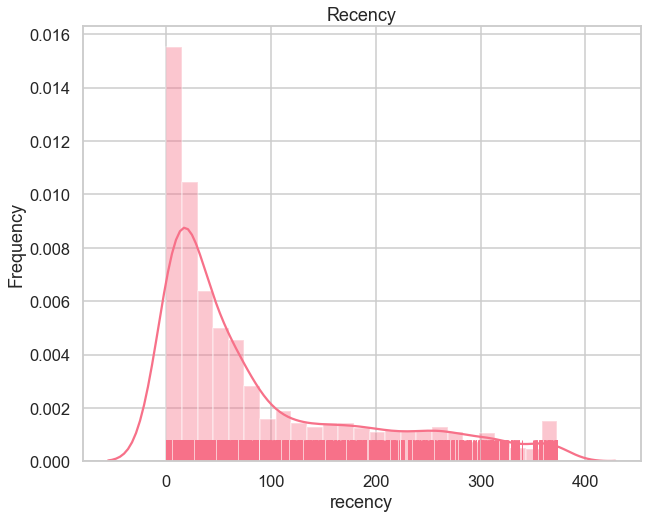

In [13]:
plt.figure(figsize=(10,8))
sns.distplot(user.recency, rug=True)
plt.ylabel('Frequency')
plt.title('Recency')

In [14]:
# Instantiate user's recency for cluster
recency_df = user[['recency']]

In [15]:
# Instantiate cluster
cluster = Cluster()
k_range, distance = cluster.elbow(recency_df)

1.09s runtime on elbow function


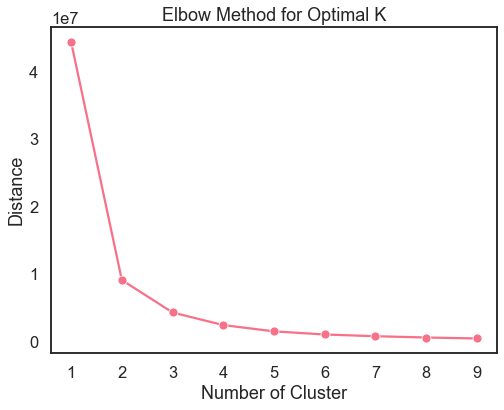

In [16]:
sns.set_style('white')
plt.figure(figsize=(8,6))

cluster.plot_elbow(k_range, distance)

3 clusters seem to be our optimal. However, we will use 4 clusters

In [17]:
# Predict and assign cluster for each customers
recency_preds = cluster.predict(4, recency_df)

user['recency_cluster'] = recency_preds
user.groupby('recency_cluster')['recency'].describe()

0.09s runtime on predict function


,count,mean,std,min,25%,50%,75%,max
recency_cluster,,,,,,,,
0,627.0,189.451356,32.948533,135.0,161.0,187.0,217.00,249.0
1,2167.0,17.538533,13.320860,0.0,6.0,16.0,28.00,48.0
2,506.0,308.851779,39.144563,250.0,274.0,305.0,350.75,373.0
3,1072.0,79.278918,23.875838,49.0,59.0,73.0,95.00,134.0


In [18]:
# Use cluster order function to re-order cluster for easy view
user_df = cluster.cluster_order('recency_cluster', 'recency', user, False)
user_df.groupby('recency_cluster')['recency'].describe()

0.01s runtime on cluster_order function


,count,mean,std,min,25%,50%,75%,max
recency_cluster,,,,,,,,
0,506.0,308.851779,39.144563,250.0,274.0,305.0,350.75,373.0
1,627.0,189.451356,32.948533,135.0,161.0,187.0,217.00,249.0
2,1072.0,79.278918,23.875838,49.0,59.0,73.0,95.00,134.0
3,2167.0,17.538533,13.320860,0.0,6.0,16.0,28.00,48.0


the order of cluster_name has reflected its attritube from 0 as inactive to 3 as active. 

In [19]:
user_df

,customer_id,recency,recency_cluster
0,17850.0,301,0
1,15100.0,329,0
2,18074.0,373,0
3,16250.0,260,0
4,13747.0,373,0
...,...,...,...
4367,13296.0,136,1
4368,17693.0,135,1
4369,15372.0,136,1
4370,13194.0,135,1


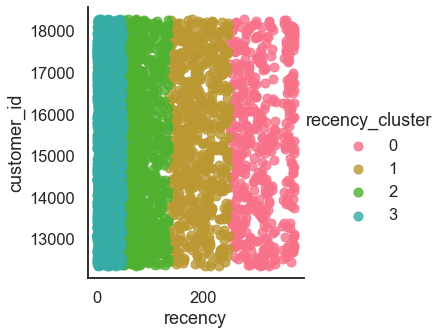

In [20]:
# Visulise clusters name by customer 
sns.lmplot(x='recency', y='customer_id', hue='recency_cluster', data=user_df, fit_reg=False)

## 2. Frequency

In [21]:
user_frequency = df.groupby('customerid')['invoicedate'].count().reset_index()
user_frequency.columns = ['customer_id', 'frequency']
user_frequency

,customer_id,frequency
0,12346.0,2
1,12347.0,182
2,12348.0,31
3,12349.0,73
4,12350.0,17
...,...,...
4367,18280.0,10
4368,18281.0,7
4369,18282.0,13
4370,18283.0,756


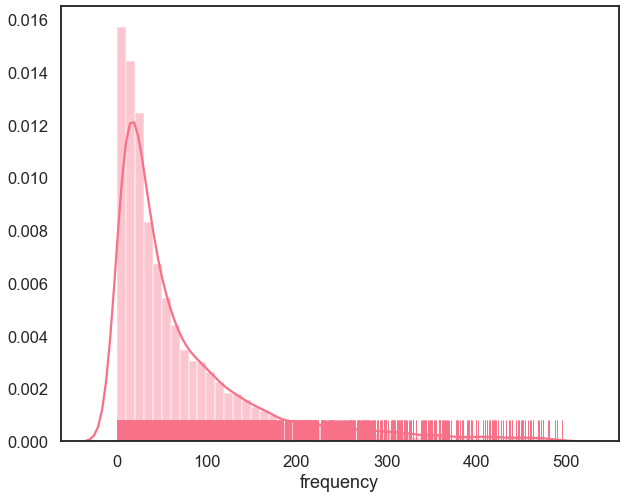

In [25]:
plt.figure(figsize=(10,8))
sns.distplot(user_frequency.query('frequency < 500')['frequency'], rug=True)

In [26]:
user_df = pd.merge(user_df, user_frequency, on='customer_id')
user_df

,customer_id,recency,recency_cluster,frequency
0,17850.0,301,0,312
1,15100.0,329,0,6
2,18074.0,373,0,13
3,16250.0,260,0,24
4,13747.0,373,0,1
...,...,...,...,...
4367,13296.0,136,1,5
4368,17693.0,135,1,18
4369,15372.0,136,1,27
4370,13194.0,135,1,3


In [27]:
user_df.frequency.describe()

count    4372.000000
mean       93.053294
std       232.471608
min         1.000000
25%        17.000000
50%        42.000000
75%       102.000000
max      7983.000000
Name: frequency, dtype: float64

0.97s runtime on elbow function


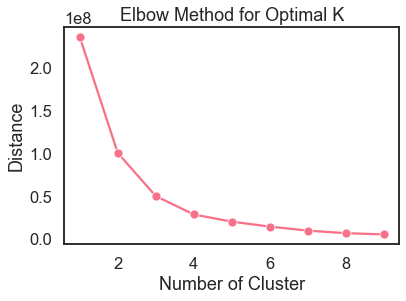

In [28]:
f_range, f_distance = cluster.elbow(user_df[['frequency']])
cluster.plot_elbow(f_range, f_distance)

In [29]:
# Predict and assign cluster for each customers
frequency_preds = cluster.predict(4, user_df[['frequency']])

user_df['frequency_cluster'] = frequency_preds
user_df.groupby('frequency_cluster')['frequency'].describe()

0.08s runtime on predict function


,count,mean,std,min,25%,50%,75%,max
frequency_cluster,,,,,,,,
0,484.0,328.528926,132.700979,189.0,227.0,285.5,392.5,803.0
1,3860.0,49.681606,44.712318,1.0,15.0,34.0,73.0,188.0
2,4.0,5914.000000,1473.845537,4642.0,5006.5,5515.5,6423.0,7983.0
3,24.0,1349.750000,508.637759,872.0,1003.5,1156.0,1541.0,2782.0


In [30]:
user_df = cluster.cluster_order('frequency_cluster', 'frequency', user_df, True)
user_df.groupby('frequency_cluster')['frequency'].describe()

0.01s runtime on cluster_order function


,count,mean,std,min,25%,50%,75%,max
frequency_cluster,,,,,,,,
0,3860.0,49.681606,44.712318,1.0,15.0,34.0,73.0,188.0
1,484.0,328.528926,132.700979,189.0,227.0,285.5,392.5,803.0
2,24.0,1349.750000,508.637759,872.0,1003.5,1156.0,1541.0,2782.0
3,4.0,5914.000000,1473.845537,4642.0,5006.5,5515.5,6423.0,7983.0


 0 - 3 clusters as similar to recency. 3 is the most favourable as this cluster has the most frequency

## 3. Monetary

In [31]:
df.head(1)

,invoiceno,stockcode,description,quantity,invoicedate,unitprice,customerid,country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom


In [32]:
df['revenue'] = df.quantity * df.unitprice
user_revenue = df.groupby('customerid')['revenue'].sum().reset_index()
user_revenue.columns = ['customer_id', 'revenue']
user_revenue

,customer_id,revenue
0,12346.0,0.00
1,12347.0,4310.00
2,12348.0,1797.24
3,12349.0,1757.55
4,12350.0,334.40
...,...,...
4367,18280.0,180.60
4368,18281.0,80.82
4369,18282.0,176.60
4370,18283.0,2094.88


In [33]:
user_df = pd.merge(user_df, user_revenue, on='customer_id')
user_df

,customer_id,recency,recency_cluster,frequency,frequency_cluster,revenue
0,17850.0,301,0,312,1,5288.63
1,15808.0,305,0,210,1,3724.77
2,13047.0,31,3,196,1,3079.10
3,12583.0,2,3,251,1,7187.34
4,14688.0,7,3,359,1,5107.38
...,...,...,...,...,...,...
4367,14456.0,4,3,977,2,3047.63
4368,12748.0,0,3,4642,3,29072.10
4369,14911.0,0,3,5903,3,132572.62
4370,17841.0,1,3,7983,3,40340.78


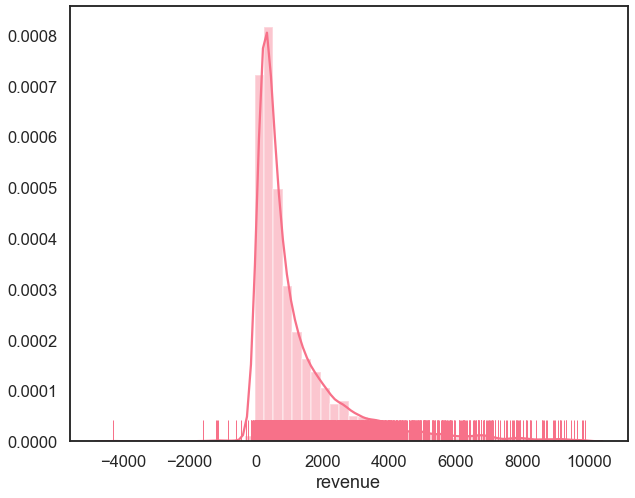

In [34]:
plt.figure(figsize=(10,8))
sns.distplot(user_df.query('revenue<10000')['revenue'], rug=True)

There is negative values for revenue. an indication of refund or product return. 

In [35]:
revenue_preds = cluster.predict(4, user_df[['revenue']])

user_df['revenue_cluster'] = revenue_preds
user_df.groupby('revenue_cluster')['revenue'].describe()

0.08s runtime on predict function


,count,mean,std,min,25%,50%,75%,max
revenue_cluster,,,,,,,,
0,4246.0,1150.834871,1379.417893,-4287.63,285.7775,622.865,1466.4525,8025.02
1,3.0,241136.560000,47874.073443,187482.17,221960.3300,256438.490,267963.7550,279489.02
2,108.0,14989.430833,7527.768535,8093.59,9802.4500,11943.265,17011.7525,40340.78
3,15.0,71423.516000,28632.631870,50415.49,52287.2800,57385.880,77008.7300,132572.62


In [36]:
user_df = cluster.cluster_order('revenue_cluster', 'revenue', user_df, True)

0.01s runtime on cluster_order function


In [37]:
user_df.groupby('revenue_cluster')['revenue'].describe()

,count,mean,std,min,25%,50%,75%,max
revenue_cluster,,,,,,,,
0,4246.0,1150.834871,1379.417893,-4287.63,285.7775,622.865,1466.4525,8025.02
1,108.0,14989.430833,7527.768535,8093.59,9802.4500,11943.265,17011.7525,40340.78
2,15.0,71423.516000,28632.631870,50415.49,52287.2800,57385.880,77008.7300,132572.62
3,3.0,241136.560000,47874.073443,187482.17,221960.3300,256438.490,267963.7550,279489.02


We have re-ordered the cluster again as similar to above method with cluster 3 is the most favourable in term of monetary

In [38]:
user_df.head()

,customer_id,recency,recency_cluster,frequency,frequency_cluster,revenue,revenue_cluster
0,17850.0,301,0,312,1,5288.63,0
1,15808.0,305,0,210,1,3724.77,0
2,13047.0,31,3,196,1,3079.10,0
3,12583.0,2,3,251,1,7187.34,0
4,14688.0,7,3,359,1,5107.38,0


## Overall Score

we have created 3 type of cluster (recency, frequency, monetary) with the higher value of cluster the better/favourable customer. Therefore, we can add these cluster value together to show the top customer for online retail dataset. The customer with the highest score indicated recent purchase, high purchase frequency(repeated purchase) and top spending.    

In [39]:
user_df['score'] = user_df['recency_cluster'] + user_df['frequency_cluster'] + user_df['revenue_cluster']

In [40]:
user_df.groupby('score')['recency', 'frequency', 'revenue'].mean()

<ipython-input-40-fe011c3a2e75>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  user_df.groupby('score')['recency', 'frequency', 'revenue'].mean()


,recency,frequency,revenue
score,,,
0,308.875000,22.273810,343.315179
1,190.017713,32.996779,538.352208
2,80.199807,46.506757,915.294220
3,20.633508,70.584642,1251.526976
4,13.284974,304.054404,4394.660233
5,7.048780,507.060976,14026.836463
6,7.916667,970.250000,41238.820833
7,2.555556,2432.555556,98056.746667
8,1.333333,4372.000000,156394.183333


In [41]:
user_df['segment'] = 'Low-Value'
user_df.loc[user_df.score > 2, 'segment'] = 'Mid-Value'
user_df.loc[user_df.score > 4, 'segment'] = 'High-Value'

In [42]:
user_df

,customer_id,recency,recency_cluster,frequency,frequency_cluster,revenue,revenue_cluster,score,segment
0,17850.0,301,0,312,1,5288.63,0,1,Low-Value
1,15808.0,305,0,210,1,3724.77,0,1,Low-Value
2,13047.0,31,3,196,1,3079.10,0,4,Mid-Value
3,12583.0,2,3,251,1,7187.34,0,4,Mid-Value
4,14688.0,7,3,359,1,5107.38,0,4,Mid-Value
...,...,...,...,...,...,...,...,...,...
4367,12748.0,0,3,4642,3,29072.10,1,7,High-Value
4368,17841.0,1,3,7983,3,40340.78,1,7,High-Value
4369,17450.0,7,3,351,1,187482.17,3,7,High-Value
4370,18102.0,0,3,433,1,256438.49,3,7,High-Value


D:\Ricky\envs\Python 38 and R\lib\site-packages\pandas\core\series.py:679: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


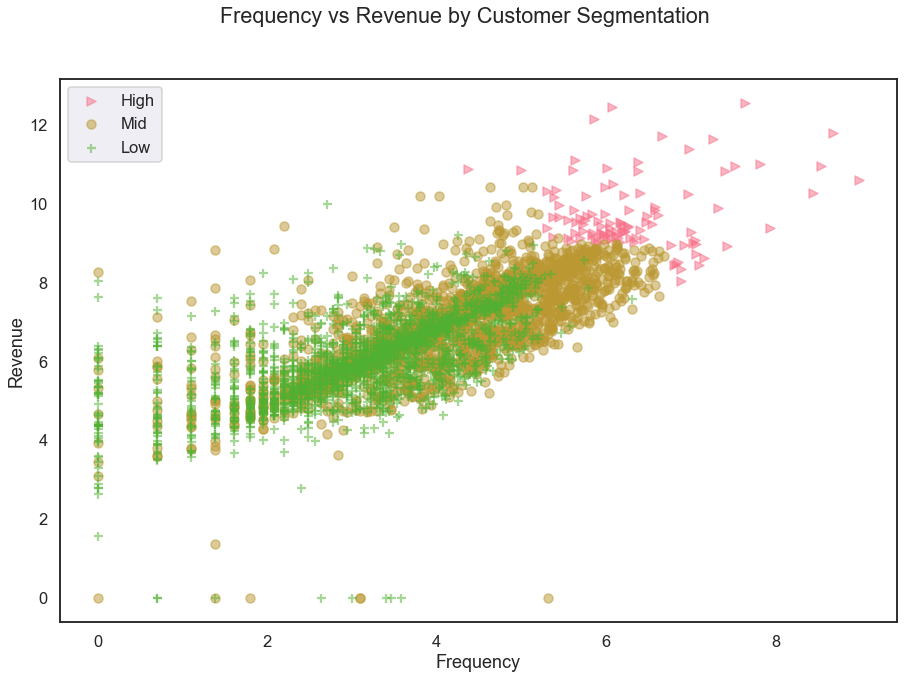

In [43]:
fig, ax = plt.subplots(figsize=(15,10))
sns.set_style('darkgrid')

ax.scatter(np.log(user_df.query('segment == "High-Value"')['frequency']), np.log(user_df.query('segment == "High-Value"')['revenue']+1), marker='>', alpha=0.5, label='High')
ax.scatter(np.log(user_df.query('segment == "Mid-Value"')['frequency']), np.log(user_df.query('segment == "Mid-Value"')['revenue']+1), marker='o', alpha=0.5, label='Mid')
ax.scatter(np.log(user_df.query('segment == "Low-Value"')['frequency']), np.log(user_df.query('segment == "Low-Value"')['revenue']+1), marker='+', alpha=0.5, label='Low')
ax.set_xlabel('Frequency')
ax.set_ylabel('Revenue')
fig.suptitle('Frequency vs Revenue by Customer Segmentation')

plt.legend()
plt.show()

D:\Ricky\envs\Python 38 and R\lib\site-packages\pandas\core\series.py:679: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


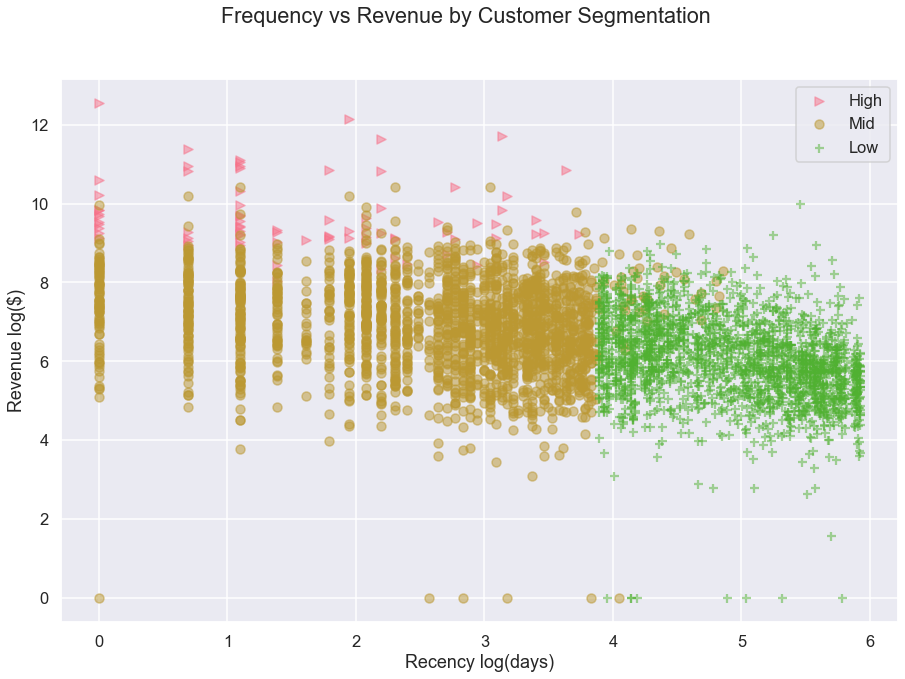

In [44]:
fig, ax = plt.subplots(figsize=(15,10))
sns.set_style('darkgrid')

ax.scatter(np.log(user_df.query('segment == "High-Value"')['recency']), np.log(user_df.query('segment == "High-Value"')['revenue']+1), marker='>', alpha=0.5, label='High')
ax.scatter(np.log(user_df.query('segment == "Mid-Value"')['recency']), np.log(user_df.query('segment == "Mid-Value"')['revenue']+1), marker='o', alpha=0.5, label='Mid')
ax.scatter(np.log(user_df.query('segment == "Low-Value"')['recency']), np.log(user_df.query('segment == "Low-Value"')['revenue']+1), marker='+', alpha=0.5, label='Low')
ax.set_xlabel('Recency log(days)')
ax.set_ylabel('Revenue log($)')
fig.suptitle('Frequency vs Revenue by Customer Segmentation')

plt.legend()
plt.show()

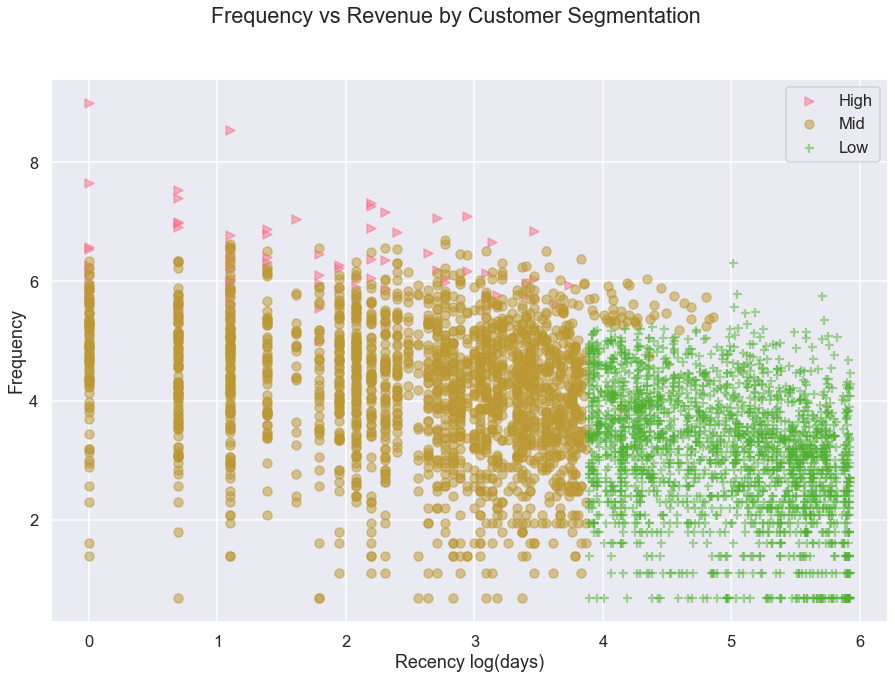

In [45]:
fig, ax = plt.subplots(figsize=(15,10))
sns.set_style('darkgrid')

ax.scatter(np.log(user_df.query('segment == "High-Value"')['recency']), np.log(user_df.query('segment == "High-Value"')['frequency']+1), marker='>', alpha=0.5, label='High')
ax.scatter(np.log(user_df.query('segment == "Mid-Value"')['recency']), np.log(user_df.query('segment == "Mid-Value"')['frequency']+1), marker='o', alpha=0.5, label='Mid')
ax.scatter(np.log(user_df.query('segment == "Low-Value"')['recency']), np.log(user_df.query('segment == "Low-Value"')['frequency']+1), marker='+', alpha=0.5, label='Low')
ax.set_xlabel('Recency log(days)')
ax.set_ylabel('Frequency')
fig.suptitle('Frequency vs Revenue by Customer Segmentation')

plt.legend()
plt.show()

In [47]:
user_df_t = user_df[['score', 'segment', 'customer_id']]
user_df_t

,score,segment,customer_id
0,1,Low-Value,17850.0
1,1,Low-Value,15808.0
2,4,Mid-Value,13047.0
3,4,Mid-Value,12583.0
4,4,Mid-Value,14688.0
...,...,...,...
4367,7,High-Value,12748.0
4368,7,High-Value,17841.0
4369,7,High-Value,17450.0
4370,7,High-Value,18102.0


In [54]:
df

,invoiceno,stockcode,description,quantity,invoicedate,unitprice,customerid,country,revenue
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
...,...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680.0,France,10.20
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France,12.60
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France,16.60
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France,16.60


In [55]:
csv = df.merge(user_df_t, left_on='customerid', right_on='customer_id', how='left')

In [61]:
csv.drop('customer_id', axis=1, inplace=True)

In [62]:
csv.head()

,invoiceno,stockcode,description,quantity,invoicedate,unitprice,customerid,country,revenue,score,segment
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30,1,Low-Value
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,1,Low-Value
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00,1,Low-Value
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,1,Low-Value
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,1,Low-Value


In [63]:
csv.to_csv('online_retail_rfmscore.csv', index=False)